# Data Exploration

## Trying BioGPT

In [59]:
import os
import sys
from typing import List
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)
 
import fire
import torch
from datasets import load_dataset
import pandas as pd
 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
 
%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)
 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /opt/conda/envs/python39/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


/opt/conda/envs/python39/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /opt/conda did not contain libcudart.so as expected! Searching further paths...
  warn(msg)


'cuda'

In [4]:
tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")
model = BioGptForCausalLM.from_pretrained("microsoft/biogpt")

In [54]:
sentence = ''' instruction: draft impression of radiology report from this clinical information and findings.

clinical information: locally recurrent oral tongue squamous cell carcinoma referred here for consideration of clinical trial participation.

findings: There are post-treatment findings in the neck related to partial right glossectomy with mandibulectomy, flap reconstruction, and neck dissection. There is an infiltrative heterogeneous mass in the left masticator, parapharyngeal, and pharyngeal mucosal spaces, with associated left mandible, posterior maxillary sinus wall, and central skull base erosion and extension into the left middle cranial fossa. There is partial opacification of the bilateral maxillary sinuses and complete left tympanomastoid opacification. There is a cluster of prominent left level 6 lymph nodes. The thyroid gland appears unremarkable. The orbits are unremarkable.

impression:
'''
inputs = tokenizer(sentence, return_tensors="pt")

In [57]:
with torch.no_grad():
    beam_output = model.generate(**inputs,
                                min_length=100,
                                max_length=2048,
                                num_beams=5,
                                early_stopping=True
                                )

In [58]:
tokenizer.decode(beam_output[0], skip_special_tokens=True)

'instruction: draft impression of radiology report from this clinical information and findings. clinical information: locally recurrent oral tongue squamous cell carcinoma referred here for consideration of clinical trial participation. findings: There are post-treatment findings in the neck related to partial right glossectomy with mandibulectomy, flap reconstruction, and neck dissection. There is an infiltrative heterogeneous mass in the left masticator, parapharyngeal, and pharyngeal mucosal spaces, with associated left mandible, posterior maxillary sinus wall, and central skull base erosion and extension into the left middle cranial fossa. There is partial opacification of the bilateral maxillary sinuses and complete left tympanomastoid opacification. There is a cluster of prominent left level 6 lymph nodes. The thyroid gland appears unremarkable. The orbits are unremarkable. impression: a.'

## Reading json, obtain the label, convert to DataFrame, create instructions

In [14]:
import gcsfs
import json

gcs_file_system = gcsfs.GCSFileSystem(project="capstone")
gcs_json_path = "gs://radiology-data/report_CT.json"
with gcs_file_system.open(gcs_json_path) as f:
    data = json.load(f)

In [23]:
s = data.get("Report_6").get("findings_group")

In [49]:
data.get("Report_6")

{'report_id': 6,
 'modality': 'CT',
 'clinical_information': {'clinical_information': 'locally recurrent oral tongue squamous cell carcinoma referred here for consideration of clinical trial participation.',
  'background': {'locally recurrent oral tongue squamous cell carcinoma': {'clinical finding': 'locally recurrent oral tongue squamous cell carcinoma',
    'cf_snomed': {'squamous cell carcinoma': 402815007},
    'existence': 'pos_dx',
    'descriptive_term': 'locally recurrent oral tongue squamous cell',
    'observation': 'carcinoma'}}},
 'findings_group': {'findings': 'There are post-treatment findings in the neck related to partial right glossectomy with mandibulectomy, flap reconstruction, and neck dissection. There is an infiltrative heterogeneous mass in the left masticator, parapharyngeal, and pharyngeal mucosal spaces, with associated left mandible, posterior maxillary sinus wall, and central skull base erosion and extension into the left middle cranial fossa. There is par

In [35]:
s.get('findings_sentences').get('Sentence-1').keys() 

dict_keys(['report_sid_fin', 'sentence_fin', 'anatomical entity_fin', 'location descriptor_fin', 'procedure_fin', 'clinical findings_fin'])

In [43]:
s.get('findings_sentences').get('Sentence-6')

{'report_sid_fin': 60.0,
 'sentence_fin': 'the orbits are unremarkable',
 'anatomical entity_fin': {'orbits': {}},
 'clinical findings_fin': {'orbits are unremarkable': {'clinical finding': 'orbits are unremarkable'}}}

In [45]:
s.get('findings_sentences').get('Sentence-1')

{'report_sid_fin': 55.0,
 'sentence_fin': 'there are post-treatment findings in the neck related to partial right glossectomy with mandibulectomy, flap reconstruction, and neck dissection',
 'anatomical entity_fin': {'neck': {}},
 'location descriptor_fin': ['right'],
 'procedure_fin': ['treatment'],
 'clinical findings_fin': {'post-treatment': {'clinical finding': 'post-treatment',
   'existence': 'pos_dx',
   'observation': 'post'},
  'mandibulectomy': {'clinical finding': 'mandibulectomy',
   'existence': 'pos_dx',
   'observation': 'mandibulectomy'},
  'flap reconstruction': {'clinical finding': 'flap reconstruction',
   'existence': 'pos_dx',
   'descriptive_term': 'flap',
   'observation': 'reconstruction'},
  'neck dissection': {'clinical finding': 'neck dissection',
   'existence': 'pos_dx',
   'descriptive_term': 'neck',
   'observation': 'dissection'}}}

In [44]:
s.get('findings_sentences').get('Sentence-4')

{'report_sid_fin': 58.0,
 'sentence_fin': 'there is a cluster of prominent left level 6 lymph nodes',
 'location descriptor_fin': ['left'],
 'clinical findings_fin': {'prominent left level 6 lymph nodes': {'clinical finding': 'prominent left level 6 lymph nodes',
   'existence': 'pos_dx',
   'descriptive_term': 'prominent left level 6 lymph',
   'observation': 'node',
   'strength_term': 'prominent'}}}

In [15]:
full_report = []
for key, value in data.items():
    report = dict()
    report_id = value['report_id']
    try:
        clinical_information = value['clinical_information']['clinical_information']
    except KeyError:
        clinical_information = "" 
    findings_group = value['findings_group']['findings']
    impression_group = value['impression_group']['impression']
    full_report.append(report)
    report['report_id'] = report_id
    report['clinical_information'] = clinical_information
    report['findings'] = findings_group
    report['impression'] = impression_group

In [16]:
import pandas as pd
CT_report = pd.DataFrame(full_report)

In [17]:
CT_report.head()

,report_id,clinical_information,findings,impression
0,6,locally recurrent oral tongue squamous cell ca...,There are post-treatment findings in the neck ...,Postoperative findings with evidence of recurr...
1,7,64 years old male with history of left humerus...,". Scattered pulmonary micronodules, some which...",No evidence of metastatic disease.
2,13,"female, 57 years old, with subarachnoid hemorr...",A large coil mass is redemonstrated in the reg...,Redemonstration of a large coil mass situated ...
3,14,"male, 66 years old, status post subdural hemor...",Findings are redemonstrated compatible with su...,No significant change in the size of bilateral...
4,15,empty.,The ventricles and sulci are within normal lim...,No acute intracranial hemorrhage.


In [18]:
CT_report["clinical_information"] = CT_report["clinical_information"].apply(lambda x: "" if x == "empty." else x) 

In [19]:
CT_report["findings"] = CT_report["findings"].apply(lambda x: "" if x == "empty" else x) 

### Change it back to JSON instruction format

In [20]:
dataset_data = [
    {
        "instruction": "Find the conclusion from the findings obtained in the radiology examination",
        "input": "Background of the patient is " + row_report["clinical_information"] + " Examination findings is " + row_report["findings"],
        "output": row_report["impression"]
    }
    for row_report in CT_report.to_dict(orient="records")
]
 
dataset_data[0]

{'instruction': 'Find the conclusion from the findings obtained in the radiology examination',
 'input': 'Background of the patient is locally recurrent oral tongue squamous cell carcinoma referred here for consideration of clinical trial participation. Examination findings is There are post-treatment findings in the neck related to partial right glossectomy with mandibulectomy, flap reconstruction, and neck dissection. There is an infiltrative heterogeneous mass in the left masticator, parapharyngeal, and pharyngeal mucosal spaces, with associated left mandible, posterior maxillary sinus wall, and central skull base erosion and extension into the left middle cranial fossa. There is partial opacification of the bilateral maxillary sinuses and complete left tympanomastoid opacification. There is a cluster of prominent left level 6 lymph nodes. The thyroid gland appears unremarkable. The orbits are unremarkable.',
 'output': 'Postoperative findings with evidence of recurrent tumor in the

In [21]:
import json
with open("alpaca-radiology-report.json", "w") as f:
    json.dump(dataset_data, f)

In [3]:
BASE_MODEL = "decapoda-research/llama-7b-hf"
 
model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
 
tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
 
tokenizer.pad_token_id = (
    0  # unk. we want this to be different from the eos token
)
tokenizer.padding_side = "left"

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/tmp/ipykernel_12982/542597409.py:3 in <module>                                              │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/var/tmp/ipykernel_12982/542597409.py'                     │
│                                                                                                  │
│ /opt/conda/envs/python39/lib/python3.9/site-packages/transformers/modeling_utils.py:2740 in      │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   2737 │   │   │   │   │   key: device_map[key] for key in device_map.keys() if key not in modu  │
│   2738 │   │   │   │   }                                                                         │
│   2739 │   │   │   │   if "cpu" in device_map_without_lm_head.values() or "disk" in device_map_  │
│ ❱ 2740 │   │   │   │   │   raise ValueError(                                                     │
│   2741 │   │   │   │   │   │   """                                                               │
│   2742 │   │   │   │   │   │   Some modules are dispatched on the CPU or the disk. Make sure yo  │
│   2743 │   │   │   │   │   │   the quantized model. If you want to dispatch the model on the CP  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: 
                        Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to 
fit
                        the quantized model. If you want to dispatch the model on the CPU or the disk while keeping
                        these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a 
custom
                        `device_map` to `from_pretrained`. Check
                        https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-
cpu-and-gpu
                        for more details.

In [4]:
data = load_dataset("json", data_files="alpaca-radiology-report.json")
data["train"]

Found cached dataset json (/home/jupyter/.cache/huggingface/datasets/json/default-e79d2a9aec3213b9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 246824
})

In [5]:
def generate_prompt(data_point):
    
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""
 
 
def tokenize(prompt, add_eos_token=True):
    CUTOFF_LEN = 900
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)
 
    result["labels"] = result["input_ids"].copy()
 
    return result
 
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [6]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)
train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)
val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

Loading cached split indices for dataset at /home/jupyter/.cache/huggingface/datasets/json/default-e79d2a9aec3213b9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-9b7bddeeeb9abf3e.arrow and /home/jupyter/.cache/huggingface/datasets/json/default-e79d2a9aec3213b9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-ebd6124ff0bdeb8e.arrow
Loading cached processed dataset at /home/jupyter/.cache/huggingface/datasets/json/default-e79d2a9aec3213b9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-3dc938128a6bdc30.arrow
Loading cached processed dataset at /home/jupyter/.cache/huggingface/datasets/json/default-e79d2a9aec3213b9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-810b0b36605039c6.arrow


In [282]:
import os
os.getpid()

18147

## Train

In [59]:
import os
import sys
from typing import List
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)
 
import fire
import torch
from datasets import load_dataset
import pandas as pd
 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
 
%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)
 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /opt/conda/envs/python39/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


/opt/conda/envs/python39/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /opt/conda did not contain libcudart.so as expected! Searching further paths...
  warn(msg)


'cuda'

In [60]:
data = load_dataset("json", data_files="quarter_radiology.json")
data["train"]

Found cached dataset json (/home/jupyter/.cache/huggingface/datasets/json/default-c0f400b185080c8b/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 61706
})

In [140]:
def generate_prompt(data_point):
    
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""
 
 
def tokenize(prompt, add_eos_token=True):
    CUTOFF_LEN = 256
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)
 
    result["labels"] = result["input_ids"].copy()
 
    return result
 
def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [62]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)
train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)
val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

Loading cached split indices for dataset at /home/jupyter/.cache/huggingface/datasets/json/default-c0f400b185080c8b/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-fdd8949182cd5e1e.arrow and /home/jupyter/.cache/huggingface/datasets/json/default-c0f400b185080c8b/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-9ce7b22f198aa447.arrow


Map:   0%|          | 0/61506 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [63]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]
 
BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "experiments"

In [64]:
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 786432 || all params: 347549696 || trainable%: 0.22627900672944337


In [66]:
import transformers

In [67]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

In [68]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [69]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator
)
model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))
 
model = torch.compile(model)
 
trainer.train()
model.save_pretrained(OUTPUT_DIR)

/opt/conda/envs/python39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.612600
1000,2.000100
1500,1.899700
2000,1.841700
2500,1.797800
3000,1.767300
3500,1.733200
4000,1.724800
4500,1.702400
5000,1.677500


In [70]:
from huggingface_hub import notebook_login

notebook_login()

In [71]:
model.push_to_hub("rlmjy/biogpt_finetuned_1", use_auth_token=True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/443 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rlmjy/biogpt_finetuned_1/commit/a8980cab20b6c70ee40f0f1eea19eec0c9ff77a0', commit_message='Upload model', commit_description='', oid='a8980cab20b6c70ee40f0f1eea19eec0c9ff77a0', pr_url=None, pr_revision=None, pr_num=None)

In [115]:
import json

# Opening JSON file
with open('alpaca-radiology-report.json', 'r') as openfile:

    # Reading from json file
    json_object = json.load(openfile)

json_object[-128]

{'instruction': 'Find the conclusion from the findings obtained in the radiology examination',
 'input': 'Background of the patient is . Malignant neoplasm of head, face, and neck. History of hnc and capillary refill time, compare to previous measurements. Examination findings is Within the suprahyoid neck on the basis of size criteria for lymphadenopathy no lymphadenopathy is appreciated. Within the infrahyoid neck on the basis of size criteria for lymphadenopathy no lymphadenopathy is appreciated. Within the visceral space the thyroid gland appears intact. The airway appears patent. The visualized intracranial structures which include the posterior fossa are intact. The visualized portions of the orbits are intact. The paranasal sinuses are clear. The mastoid air cells are clear. The parotid and the submandibular glands appear intact. The visualized lung apices appear clear. The carotid and vertebral vasculature visualized on this exam appears intact. The cervical vertebral bodies in

In [167]:
len_object = len(json_object)//32
test_data = json_object[-len_object:]

In [168]:
len_object

7713

In [171]:
json_object[-128]['output']

'No evidence for local recurrence or neck lymphadenopathy on the basis of CT size criteria for lymphadenopathy.'

In [181]:
def get_output(s):
    text = s.split("Response:")[-1].split("</s>")[0].strip()
    return(text)

In [183]:
def generate_prompt_test(data_point):
    
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response: """

In [197]:
import os
os.getpid()

18147

In [20]:
from transformers import GenerationConfig

In [268]:
### testing
generation_config = GenerationConfig(
    temperature=0.6,
    top_p=0.95,
    repetition_penalty=1.15,
)

for test in test_data[5391:7713]:
    PROMPT = generate_prompt_test(test)
    original_output = test['output']
    from transformers import GenerationConfig
    inputs = tokenizer(
        PROMPT,
        return_tensors="pt",
    )
    input_ids = inputs["input_ids"].cuda()
    score = []
    generated_text = []
    for _ in range(5):
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=128,
        )
        text = ""
        for s in generation_output.sequences:
                text = text + tokenizer.decode(s)
        hypothesis = get_output(text)

        score_single = rouge_scorer.get_scores(
        hyps=hypothesis,
        refs=original_output,
        )
        score.append(score_single[0]["rouge-l"]["f"])
        generated_text.append(hypothesis)
    all_score.append(score)
    all_generated_text.append(generated_text)

In [269]:
len(all_score)

7713

In [224]:
def get_score(hypo, ref):
    score_single = rouge_scorer.get_scores(
        hyps=hypo,
        refs=ref,
        )
    return score_single[0]["rouge-l"]["f"]

In [ ]:
import json
with open("list_score", "w") as fp:
    json.dump(all_score, fp)
    
with open("list_score", "w") as fp:
    json.dump(all_generated_text, fp)

In [ ]:
all_score = []
for n, test in enumerate(test_data):
    score = []
    original_output = test['output']
    
    for hypo in all_generated_text[n]:
        score.append(get_score(hypo, original_output))
    all_score.append(score)

In [270]:
import pandas as pd
rouge_five = pd.DataFrame(all_score)

In [271]:
import numpy as np
max_rouge = rouge_five.apply(np.max, axis = 1)

In [275]:
len(rouge_five)

7713

<Axes: >

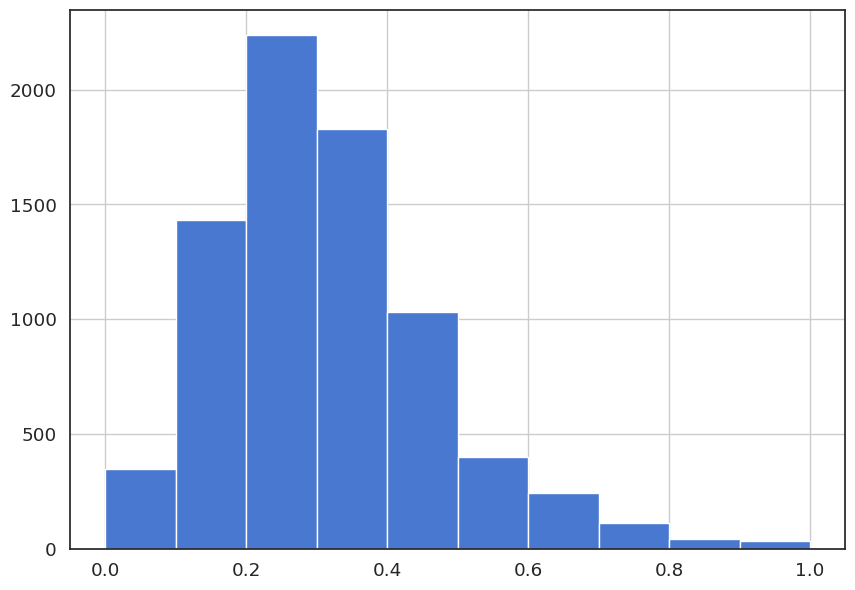

In [276]:
max_rouge.hist()

In [277]:
max_rouge.mean()

0.3173186791150795

In [104]:
from sacrebleu.metrics import BLEU
bleu_scorer = BLEU()

hypothesis = "Soft tissue nodule within the right submandibular space with mild enhancement similar to the adjacent submandibular gland. These findings may represent reactive changes related to prior treatment. No evidence of lymphadenopathy. Please see CT for further evaluation."
reference = "Right submandibular space adenopathy compatible with the stated history of lymphoma. The dominant lesion is difficult to separate from the adjacent submandibular gland and may have invaded it or arisen from it. Smaller suspicious lymph nodes are evident elsewhere in the upper right neck as above."

score = bleu_scorer.sentence_score(
    hypothesis=hypothesis,
    references=[reference],
)

score.score/100

It is recommended to enable `effective_order` for sentence-level BLEU.


0.06896550360234334

In [ ]:
from rouge import Rouge
rouge_scorer = Rouge()

hypothesis = "Soft tissue nodule within the right submandibular space with mild enhancement similar to the adjacent submandibular gland. These findings may represent reactive changes related to prior treatment. No evidence of lymphadenopathy. Please see CT for further evaluation."
reference = "Right submandibular space adenopathy compatible with the stated history of lymphoma. The dominant lesion is difficult to separate from the adjacent submandibular gland and may have invaded it or arisen from it. Smaller suspicious lymph nodes are evident elsewhere in the upper right neck as above."

score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)
score[0]["rouge-l"]["f"]


0.26666666171022224

In [109]:
from rouge import Rouge
rouge_scorer = Rouge()

hypothesis = "Stable ventricular size and configuration without evidence for acute intracranial hemorrhage. No significant interval change of right frontal lobe subarachnoid hemorrhage. Stable CT findings related to suboccipital craniectomy with an otherwise small posterior fossa and mildly low-lying cerebellar tonsils."
reference = "Right parietal approach ventricular shunt catheter, unchanged in position. Unchanged ventricular size and configuration. No intracranial hemorrhage or midline shift. Suboccipital craniectomy with slightly low-lying cerebellar tonsils, unchanged."

score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)
score[0]["rouge-l"]["f"]


0.35483870480749224

## reinforcement learning

In [280]:
# imports
import torch
from transformers import AutoTokenizer
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import respond_to_batch

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/tmp/ipykernel_18147/2057017563.py:4 in <module>                                             │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/var/tmp/ipykernel_18147/2057017563.py'                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'trl'

In [278]:
all_score[639]

[0.7999999952000001,
 0.999999995,
 0.2727272697520661,
 0.05555555358024698,
 0.34782608408317583]